In [3]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
#import libraries

import os
import math
import cv2
import struct
import glob
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import xml.etree.ElementTree as ET

In [5]:
PROCESSED_DATA = './ICDAR/ICDAR_Processed'
IMAGE_PATH = os.path.join(PROCESSED_DATA, 'image')
TABLE_MASK_PATH = os.path.join(PROCESSED_DATA, 'table_mask')
COL_MASK_PATH = os.path.join(PROCESSED_DATA, 'col_mask')
ORIG_DATA_PATH = '.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth'

In [ ]:
os.makedirs(PROCESSED_DATA, exist_ok = True)
os.makedirs(IMAGE_PATH, exist_ok = True)
os.makedirs(TABLE_MASK_PATH, exist_ok = True)
os.makedirs(COL_MASK_PATH, exist_ok = True)

In [ ]:
import xml.etree.ElementTree as ET
tree = ET.parse('cTDaR_t00005.xml')
root = tree.getroot()

In [6]:
# Function to set a value in the table
def set_value(table, row, col, value):
    table[(row, col)] = value

# Function to get a value from the table
def get_value(table, row, col):
    return table.get((row, col), None)

# Point Extraction from XMLS

### Extraction and arrangement of points for columns from XMLs

In [49]:
import math
def parrange(start_row, start_col, end_row, end_col, pointsfornow, points):
  if(end_row == None):
    end_row = start_row
  if(end_col == None):
    end_col = start_col
  rows = end_row - start_row + 1
  cols = end_col - start_col + 1
  if(rows == 1 and cols == 1):
    set_value(pointsfornow, start_row, start_col, points[0:4])
    set_value(pointsfornow, start_row, start_col, [points[0], points[1], points[math.floor((len(points)-2)/2)+1], points[math.floor((len(points)-2)/2)+2]])
  elif (rows != 1 or cols != 1) and len(points) > 4:
    left = points[:rows+1]
    top = points[rows+1:rows+cols]
    right = points[rows+cols:rows+cols+rows+1]
    bottom = points[rows+cols+rows+1:]
    right.reverse()
    bottom.reverse()
    pts1 = True if len(points) == 2*(rows+cols) else False
    L1 = True if len(left) == rows+1 else False
    R1 = True if len(left) == rows+1 else False
    T1 = True if  len(top) == cols-1 else False
    B1 = True if  len(bottom) == cols-1 else False
    master = True if pts1 and L1 and R1 and T1 and B1 else False
    for row in range(rows):
      for col in range(cols):
        if col == 0 and cols > 1 and master and len(top)>0:
          set_value(pointsfornow, start_row+row, start_col+col, [left[row], left[row+1], top[col], bottom[col]])
        elif col == cols-1 and master and len(top)>0:
          set_value(pointsfornow, start_row+row, start_col+col, [bottom[col-1], top[col-1], right[row], right[row+1]])
        elif col > 0 and col < cols-1 and master and len(top)>0:
          set_value(pointsfornow, start_row+row, start_col+col, [bottom[col-1], top[col-1], top[col], bottom[col]])
        else:
          set_value(pointsfornow, start_row+row, start_col+col, None)
  elif (rows != 1 or cols != 1):  
    for row in range(rows):
      for col in range(cols):
        set_value(pointsfornow, start_row+row, start_col+col, [points[0], points[1], points[2], points[3]])

In [8]:
def string_to_points(coord_string):
    points = coord_string.split()
    return [tuple(map(int, point.split(','))) for point in points]

In [9]:
def getall(root):
  table= []
  all_points = []
  max_col = []  # Variable to track the maximum end-col value

  for child in root: #Tables in Document
      pointsfornow = {}
      mxc = 0
      for child2 in child: #coord for table and cell in Table
        if 'points' in child2.attrib:
              table.append(string_to_points(child2.attrib['points']))
        else:
            start_row, start_col, end_row, end_col = None, None, None, None
            try:
              start_row = int(child2.attrib['start-row'])
              start_col = int(child2.attrib['start-col'])
              end_row = int(child2.attrib['end-row'])
              end_col = int(child2.attrib['end-col'])
            except(ValueError, TypeError):
              print("exception in Start/End Row/Column")
            try:
              if end_col > mxc:
                mxc = end_col
            except (ValueError, TypeError):
              print("exception in max col")
              if start_col > mxc:
                mxc = start_col
        for child3 in child2: #coord in Cell within Table
          if 'points' in child3.attrib:
                  parrange(start_row, start_col, end_row, end_col, pointsfornow, string_to_points(child3.attrib['points']))
      all_points.append(pointsfornow)
      max_col.append(mxc+1)
  return table, all_points, max_col 

## THIS is for COLUMN MASK ONLY

In [10]:
def customsort(points):
  toreturn = []
  for unsorted_dict in points:
    sorted_dict = dict(sorted(unsorted_dict.items(), key=lambda item: (item[0][0], item[0][1])))
    toreturn.append(sorted_dict)
  return toreturn

In [56]:
def toplot(all_ps, max_col):
    ret = []
    for p, all_poins in enumerate(all_ps):
      # print(len(all_poins))
      # print(all_poins.keys())
      temp_ret = []
      resultant = list(all_poins.items())[-max_col[p]:]
      replacefrm = list(all_poins.items())[:max_col[p]]

# Iterate through the dictionary keys
      resultant = dict(resultant)
      replacefrm = dict(replacefrm)
      R1 = 0
      for key1 in resultant.keys():
        A = key1[0]
        if A > R1:
          R1 = A
      R2 = 1234567890123456789012345678901234567890
      for key2 in replacefrm.keys():
        B = key2[0]
        if B < R2:
          R2 = B
      # print(resultant)
      # print(replacefrm)
      # print(max_col[p], len(resultant), len(replacefrm))
      for i in range(max_col[p]):
        # j, k = 1, 1
        # res, rep = resultant[(R1, i)],  replacefrm[(R2, i)]
        j, k = 0, 0
        res, rep = None, None
        while res == None:
          # print("j:", j,"R1:", R1, all_poins[(R1 - j, i)])
          # print(all_poins[(R1 - j, i)])
          res= all_poins[(R1 - j, i)]
          j = j+1
          if(R1-j<0):
            res= False
        while rep == None:
          # print("k:", k,"R2:", R2, all_poins[(R2 + k, i)])
          rep = all_poins[(R2 + k, i)]
          k = k+1
          # if(R1+k>R1):
          try:
            all_poins[(R2 + k, i)]
          except:  
            rep= False
        if(rep == False and res == False):
          print("!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!")
        if(rep != False and res != False):
          res[0] = rep[0]
          res[3] = rep[3]
          res[0], res[1], res[2], res[3] = list(res[0]), list(res[1]), list(res[2]), list(res[3])
          res[0][0] += 20
          res[1][0] += 20
          res[2][0] -= 20
          res[3][0] -= 20
          res[0], res[1], res[2], res[3] = tuple(res[0]), tuple(res[1]), tuple(res[2]), tuple(res[3])
          temp_ret.append(res)
        # else:
        #   #REDUCE MAX_COL[P] BY 1
      #if:
      # max_col[p] = max_col[p]-1
      # print("temp_ret:" , temp_ret)
      ret.append(temp_ret)
    return ret

# Mask Generation

In [12]:
from PIL import Image, ImageDraw

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        return width, height

# EDA

## Marmot Dataset

We will be using data in terms of

- Positive Samples : Images with table in them
- Negative Samples : Images with no table in them

In [13]:
xmls = glob.glob('./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth' + '/*.xml')
jpgs = glob.glob('./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth' + '/*.jpg')

In [14]:
xmls

['./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00000.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00001.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00002.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00003.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00004.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00005.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00006.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00007.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00008.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00009.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00010.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00018.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00019.xml',
 './ICDAR/IC

In [15]:
jpgs

['./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00000.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00001.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00002.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00003.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00004.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00005.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00006.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00007.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00008.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00009.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00010.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00018.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00019.jpg',
 './ICDAR/IC

In [ ]:
# Convert a PNG image to JPEG
def convert_png_to_jpg(png_file, jpg_file):
  """Converts a PNG image to a JPEG image.

  Args:
    png_file: The path to the PNG image file.
    jpg_file: The path to the JPEG image file.
  """

  # Open the PNG image.
  img = Image.open(png_file)

  # Convert the image to JPEG.
  img.convert("RGB").save(jpg_file, "JPEG")

# Convert a TIFF image to JPEG
def convert_tiff_to_jpg(tiff_file, jpg_file):
  """Converts a TIFF image to a JPEG image.

  Args:
    tiff_file: The path to the TIFF image file.
    jpg_file: The path to the JPEG image file.
  """

  # Open the TIFF image.
  img = Image.open(tiff_file)

  # Convert the image to JPEG.
  img.convert("RGB").save(jpg_file, "JPEG")

# Example usage:

# convert_png_to_jpg("image.png", "image.jpg")
# convert_tiff_to_jpg("image.tif", "image.jpg")

In [ ]:
tifs = glob.glob('./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth' + '/*.TIFF')
pngs = glob.glob('./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth' + '/*.png')

In [ ]:
tifs

In [ ]:
for i in tifs:
    input_path = i
    output_path = input_path.replace('.TIFF', '.jpg')
    convert_tiff_to_jpg(input_path, output_path)
    print(output_path)

In [ ]:
for i in pngs:
    input_path = i
    output_path = input_path.replace('.png', '.jpg')
    convert_png_to_jpg(input_path, output_path)
    print(output_path)

In [ ]:
len(xmls)

In [ ]:
len(jpgs)

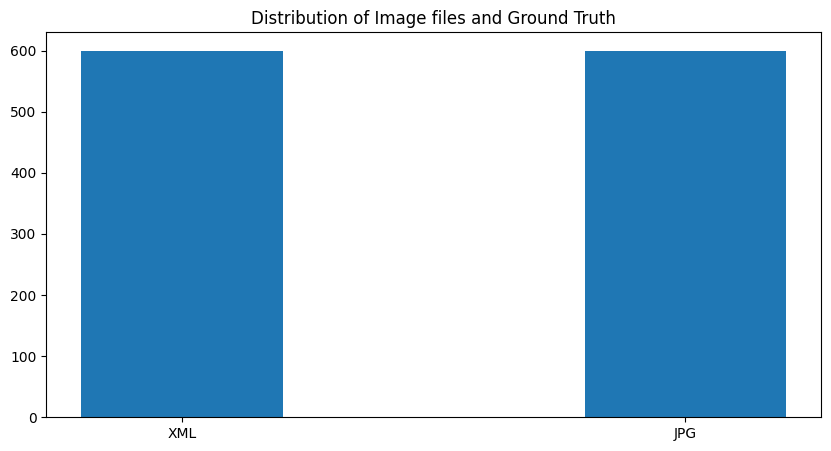

In [16]:
fig = plt.figure(figsize = (10, 5))

x = ['XML', 'JPG']
y = [len(xmls), len(jpgs)]
plt.bar(x, y,width = 0.4)
plt.title('Distribution of Image files and Ground Truth')
plt.show()

In [17]:
new_h, new_w = 1024, 1024

In [18]:
def tableplot(resultant, image_path, pathtosave):
# Define the size of the bitmap
  width, height = get_image_dimensions(image_path)

# Create a blank black image
  img = Image.new('RGB', (width, height), color='black')
  draw = ImageDraw.Draw(img)

# Define the closed areas
  closed_areas = resultant
# Draw the closed areas in white
  for area in closed_areas:
    draw.polygon(area, fill='white')

# Save the image
  img.save(pathtosave)

def colplot(resultant, image_path, pathtosave):
# Define the size of the bitmap
  width, height = get_image_dimensions(image_path)

# Create a blank black image
  img = Image.new('RGB', (width, height), color='black')
  draw = ImageDraw.Draw(img)

  for result in resultant:
  # Define the closed areas
    closed_areas = result
  # Draw the closed areas in white
    for area in closed_areas:
      draw.polygon(area, fill='white')

# Save the image
  img.save(pathtosave)

## Data Preprocessing

In [19]:
import xml.etree.ElementTree as ET

In [110]:
processed_data = []

In [109]:
# processed_data = []

for i, data in enumerate([jpgs]):
    
    for j, img_path in tqdm(enumerate(data)):
    #    if j > 99: 
        image_name = os.path.basename(img_path)
        image = Image.open(img_path)
        w, h = image.size
        #convert to RGB image
        image = image.resize((new_h, new_w))
        if image.mode != 'RGB':
            image = image.convert("RGB")
        # table_bboxes, col_bboxes = [], []
            
        #get xml filename
        xml_file = image_name.replace('.jpg', '.xml')
        xml_file = xml_file.replace('.JPG', '.xml')
        xml_path = os.path.join(ORIG_DATA_PATH, xml_file)
        # xml_file.replace(" ", "")
        #processing XML
        tree = ET.parse(xml_path)
        root = tree.getroot()
        print(j, xml_file)
        tables, all_points, max_col = getall(root)
        all_points = customsort(all_points)
        
        crds = toplot(all_points, max_col)
        # print(crds, tables)
        colmask, tablemask = os.path.join(COL_MASK_PATH, image_name), os.path.join(TABLE_MASK_PATH, image_name)
        colplot(crds, img_path, colmask)
        tableplot(tables, img_path, tablemask)
        value = (img_path, tablemask, colmask, h, w, int(tables != 0), \
                len(tables), len(crds), tables, crds)
        
        processed_data.append(value)
            # print(xml_path, w, h)
        # if j == 100:
            # break

3it [00:00,  9.57it/s]

0 cTDaR_t00000.xml
1 cTDaR_t00001.xml
2 cTDaR_t00002.xml


5it [00:00,  9.11it/s]

3 cTDaR_t00003.xml
4 cTDaR_t00004.xml


7it [00:00,  9.63it/s]

5 cTDaR_t00005.xml
6 cTDaR_t00006.xml
7 cTDaR_t00007.xml


11it [00:01, 10.24it/s]

8 cTDaR_t00008.xml
9 cTDaR_t00009.xml
10 cTDaR_t00010.xml
11 cTDaR_t00018.xml


13it [00:01,  6.67it/s]

12 cTDaR_t00019.xml


15it [00:02,  5.72it/s]

13 cTDaR_t00020.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
14 cTDaR_t00021.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


16it [00:02,  6.22it/s]

15 cTDaR_t00022.xml


17it [00:02,  5.54it/s]

16 cTDaR_t00023.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


18it [00:02,  3.85it/s]

17 cTDaR_t00024.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


20it [00:03,  4.37it/s]

18 cTDaR_t00025.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
19 cTDaR_t00026.xml


21it [00:03,  3.93it/s]

20 cTDaR_t00027.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


23it [00:04,  4.10it/s]

21 cTDaR_t00028.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
22 cTDaR_t00029.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


25it [00:04,  4.63it/s]

23 cTDaR_t00030.xml
24 cTDaR_t00031.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


26it [00:04,  4.24it/s]

25 cTDaR_t00032.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
26 cTDaR_t00033.xml


29it [00:05,  5.18it/s]

27 cTDaR_t00034.xml
28 cTDaR_t00035.xml


30it [00:05,  5.78it/s]

29 cTDaR_t00036.xml


32it [00:05,  5.67it/s]

30 cTDaR_t00037.xml
31 cTDaR_t00038.xml


33it [00:05,  6.26it/s]

32 cTDaR_t00039.xml
33 cTDaR_t00040.xml
34 cTDaR_t00041.xml


36it [00:06,  6.71it/s]

35 cTDaR_t00042.xml


37it [00:06,  5.84it/s]

36 cTDaR_t00043.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


39it [00:06,  5.17it/s]

37 cTDaR_t00044.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
38 cTDaR_t00045.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


40it [00:07,  4.76it/s]

39 cTDaR_t00046.xml


41it [00:07,  4.41it/s]

40 cTDaR_t00047.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


42it [00:07,  3.93it/s]

41 cTDaR_t00048.xml


43it [00:08,  3.90it/s]

42 cTDaR_t00049.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


44it [00:08,  3.60it/s]

43 cTDaR_t00050.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


45it [00:08,  3.71it/s]

44 cTDaR_t00051.xml


46it [00:08,  3.53it/s]

45 cTDaR_t00052.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


47it [00:09,  3.70it/s]

46 cTDaR_t00053.xml
47 cTDaR_t00054.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


49it [00:09,  3.80it/s]

48 cTDaR_t00055.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


51it [00:10,  4.35it/s]

49 cTDaR_t00056.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
50 cTDaR_t00057.xml


53it [00:10,  4.55it/s]

51 cTDaR_t00058.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
52 cTDaR_t00059.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


54it [00:10,  5.02it/s]

53 cTDaR_t00060.xml


55it [00:10,  4.65it/s]

54 cTDaR_t00061.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


56it [00:11,  4.26it/s]

55 cTDaR_t00062.xml


57it [00:11,  4.16it/s]

56 cTDaR_t00063.xml
57 cTDaR_t00064.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


59it [00:11,  4.38it/s]

58 cTDaR_t00065.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


60it [00:12,  4.31it/s]

59 cTDaR_t00066.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


61it [00:12,  3.64it/s]

60 cTDaR_t00067.xml
61 cTDaR_t00068.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


63it [00:12,  3.89it/s]

62 cTDaR_t00069.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


64it [00:13,  4.14it/s]

63 cTDaR_t00070.xml


65it [00:13,  4.30it/s]

64 cTDaR_t00091.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


66it [00:13,  4.39it/s]

65 cTDaR_t00092.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
66 cTDaR_t00093.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


69it [00:14,  4.72it/s]

67 cTDaR_t00094.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
68 cTDaR_t00095.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


70it [00:14,  4.80it/s]

69 cTDaR_t00096.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


72it [00:14,  4.91it/s]

70 cTDaR_t00097.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
71 cTDaR_t00098.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


73it [00:15,  4.94it/s]

72 cTDaR_t00099.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


74it [00:15,  4.95it/s]

73 cTDaR_t00100.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


75it [00:15,  4.85it/s]

74 cTDaR_t00101.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
75 cTDaR_t00116.xml


79it [00:15,  7.44it/s]

76 cTDaR_t00117.xml
77 cTDaR_t00118.xml
78 cTDaR_t00119.xml


82it [00:16,  8.60it/s]

79 cTDaR_t00120.xml
80 cTDaR_t00121.xml
81 cTDaR_t00122.xml


83it [00:16,  3.95it/s]

82 cTDaR_t00125.xml


84it [00:17,  2.73it/s]

83 cTDaR_t00126.xml


85it [00:18,  2.24it/s]

84 cTDaR_t00127.xml


86it [00:19,  1.79it/s]

85 cTDaR_t00128.xml


87it [00:19,  1.64it/s]

86 cTDaR_t00129.xml


88it [00:20,  1.54it/s]

87 cTDaR_t00130.xml


89it [00:21,  1.38it/s]

88 cTDaR_t00131.xml


90it [00:22,  1.39it/s]

89 cTDaR_t00132.xml


91it [00:23,  1.34it/s]

90 cTDaR_t00133.xml


92it [00:23,  1.34it/s]

91 cTDaR_t00134.xml


93it [00:24,  1.35it/s]

92 cTDaR_t00135.xml


94it [00:25,  1.35it/s]

93 cTDaR_t00136.xml


95it [00:26,  1.31it/s]

94 cTDaR_t00137.xml


96it [00:26,  1.32it/s]

95 cTDaR_t00138.xml


97it [00:27,  1.27it/s]

96 cTDaR_t00139.xml


98it [00:28,  1.30it/s]

97 cTDaR_t00140.xml


99it [00:29,  1.31it/s]

98 cTDaR_t00141.xml


100it [00:29,  1.34it/s]

99 cTDaR_t00142.xml


101it [00:30,  1.28it/s]

100 cTDaR_t00143.xml


102it [00:31,  1.32it/s]

101 cTDaR_t00144.xml


103it [00:32,  1.31it/s]

102 cTDaR_t00145.xml


104it [00:32,  1.46it/s]

103 cTDaR_t00167.xml


105it [00:33,  1.65it/s]

104 cTDaR_t00168.xml


107it [00:33,  2.12it/s]

105 cTDaR_t00169.xml
106 cTDaR_t00170.xml


108it [00:34,  2.32it/s]

107 cTDaR_t00171.xml


109it [00:34,  2.10it/s]

108 cTDaR_t00172.xml


110it [00:35,  1.56it/s]

109 cTDaR_t00173.xml


111it [00:36,  1.40it/s]

110 cTDaR_t00174.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


112it [00:36,  1.75it/s]

111 cTDaR_t00177.xml


113it [00:37,  2.11it/s]

112 cTDaR_t00178.xml


114it [00:37,  2.52it/s]

113 cTDaR_t00179.xml


115it [00:37,  2.77it/s]

114 cTDaR_t00180.xml


116it [00:37,  3.07it/s]

115 cTDaR_t00181.xml


117it [00:38,  3.27it/s]

116 cTDaR_t00182.xml


118it [00:38,  3.60it/s]

117 cTDaR_t00183.xml


119it [00:38,  3.84it/s]

118 cTDaR_t00184.xml


120it [00:38,  3.89it/s]

119 cTDaR_t00185.xml


121it [00:39,  4.07it/s]

120 cTDaR_t00186.xml


122it [00:39,  4.22it/s]

121 cTDaR_t00187.xml


123it [00:39,  4.37it/s]

122 cTDaR_t00188.xml


124it [00:39,  4.54it/s]

123 cTDaR_t00189.xml


125it [00:39,  4.66it/s]

124 cTDaR_t00190.xml


126it [00:40,  3.51it/s]

125 cTDaR_t00191.xml
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!works!!!!!!!!!!!!!!!!!!!!!


127it [00:40,  3.63it/s]

126 cTDaR_t00192.xml
127 cTDaR_t00198.xml


129it [00:41,  3.37it/s]

128 cTDaR_t00199.xml


130it [00:41,  2.70it/s]

129 cTDaR_t00200.xml


131it [00:42,  2.43it/s]

130 cTDaR_t00201.xml


132it [00:42,  2.23it/s]

131 cTDaR_t00202.xml


133it [00:43,  2.12it/s]

132 cTDaR_t00203.xml


134it [00:44,  2.02it/s]

133 cTDaR_t00204.xml


135it [00:44,  1.84it/s]

134 cTDaR_t00205.xml


136it [00:45,  1.87it/s]

135 cTDaR_t00206.xml


137it [00:45,  1.75it/s]

136 cTDaR_t00207.xml


138it [00:46,  1.54it/s]

137 cTDaR_t00208.xml


139it [00:47,  1.54it/s]

138 cTDaR_t00209.xml


140it [00:47,  1.81it/s]

139 cTDaR_t00228.xml


141it [00:47,  2.12it/s]

140 cTDaR_t00229.xml


143it [00:48,  2.86it/s]

141 cTDaR_t00230.xml
142 cTDaR_t00231.xml


143it [00:48,  2.94it/s]


KeyboardInterrupt: 

In [69]:
column_name = ['img_path','table_mask','col_mask','original_height','original_width','hasTable','table_count','col_count','table_bboxes','col_bboxes']
processed_data = pd.DataFrame(processed_data, columns=column_name)

In [70]:
processed_data.to_csv("processed_data.csv", index = False)

In [62]:
processed_data.head()

,img_path,table_mask,col_mask,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes
0,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0000...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00000.jpg,3584,4912,1,1,1,"[[(1722, 698), (3961, 698), (3961, 3247), (172...","[[[(1742, 698), (1695, 3239), (1740, 3239), (1..."
1,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0000...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00001.jpg,3584,4912,1,2,2,"[[(130, 538), (2398, 615), (2327, 3112), (128,...","[[[(129, 542), (69, 3073), (106, 3073), (153, ..."
2,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0000...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00002.jpg,3584,4912,1,2,2,"[[(149, 521), (2425, 639), (2317, 3117), (163,...","[[[(162, 526), (138, 1173), (48, 3065), (182, ..."
3,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0000...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00003.jpg,3584,4912,1,2,2,"[[(296, 237), (2461, 473), (2209, 3015), (346,...","[[[(323, 228), (33, 2780), (97, 2792), (363, 2..."
4,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0000...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00004.jpg,3584,4912,1,2,2,"[[(169, 374), (2278, 462), (2265, 3022), (180,...","[[[(183, 385), (85, 3064), (145, 3064), (231, ..."


In [71]:
processed_data = pd.read_csv('processed_data.csv')

In [72]:
processed_data.head()

,img_path,table_mask,col_mask,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes
0,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0000...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00000.jpg,3584,4912,1,1,1,"[[(1722, 698), (3961, 698), (3961, 3247), (172...","[[[(1742, 698), (1695, 3239), (1740, 3239), (1..."
1,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0000...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00001.jpg,3584,4912,1,2,2,"[[(130, 538), (2398, 615), (2327, 3112), (128,...","[[[(129, 542), (69, 3073), (106, 3073), (153, ..."
2,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0000...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00002.jpg,3584,4912,1,2,2,"[[(149, 521), (2425, 639), (2317, 3117), (163,...","[[[(162, 526), (138, 1173), (48, 3065), (182, ..."
3,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0000...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00003.jpg,3584,4912,1,2,2,"[[(296, 237), (2461, 473), (2209, 3015), (346,...","[[[(323, 228), (33, 2780), (97, 2792), (363, 2..."
4,./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/groun...,./ICDAR/ICDAR_Processed\table_mask\cTDaR_t0000...,./ICDAR/ICDAR_Processed\col_mask\cTDaR_t00004.jpg,3584,4912,1,2,2,"[[(169, 374), (2278, 462), (2265, 3022), (180,...","[[[(183, 385), (85, 3064), (145, 3064), (231, ..."


## Advanced EDA

In [ ]:
processed_data['hasTable'].value_counts().tolist()

#### Positive : Negative Ratio

In [ ]:
fig = plt.figure(figsize = (10, 5))

x = ['Neg Samples', 'Pos Samples']
data = processed_data['hasTable'].value_counts().tolist()
y = [data[1],data[0]]
plt.bar(x, y,width = 0.4)
plt.title('Distribution of Positive and Negative Samples')
plt.show()

#### Columns without any Table

In [ ]:
processed_data[(processed_data['table_count']==0)]

#### Table with No Columns

In [ ]:
processed_data[(processed_data['hasTable']==1) & (processed_data['col_count']==0)]

#### plotting image with table but no columns

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.1.2010_5.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.1.2107_9.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.160.669_3.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.7.2174_3.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.7.2174_8.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

### Observations

- There are 5 images with tables but no columns
- There are total 494 Negative Samples and 499 Positive Samples.
- Also, we confirmed that there are no columns with only tables.

### Height of the Image

In [ ]:
processed_data['original_height'].plot.hist(bins = 10)

In [ ]:
sns.kdeplot(processed_data['original_height'], color='b', fill=True)
  
plt.xlabel('Height')
plt.ylabel('Probability Density')
plt.show()

### Width of the Image

In [ ]:
processed_data['original_width'].plot.hist(bins = 10)

In [ ]:
sns.kdeplot(processed_data['original_width'], color='b', fill=True)

plt.xlabel('Width')
plt.ylabel('Probability Density')
plt.show()

### Total Tables

In [ ]:
processed_data['table_count'].value_counts().plot.bar()
plt.xlabel('Tables')
plt.ylabel('Count')
plt.show()

### Total Columns

In [ ]:
processed_data['col_count'].value_counts().plot.bar()
plt.xlabel('Columns')
plt.ylabel('Count')
plt.show()

In [ ]:
import json


### Observations

- Height of most images are between 1000 - 1100
- Width of most images are between 700-800.
- Apart from images with no Tables, most images contains only 1 table and at maximum 4 tables.
- Total Columns in an image (can have multiple tables in a page) ranges from 4 - 42
- We have also seen Image with no columns but have Tables in them.

### Height of Table

In [ ]:
heights = []
widths = []
for boxes in processed_data[processed_data['hasTable']==1]['table_bboxes']:
    # boxes = [json.loads('[' + boxes.strip('][').strip(',') + ']')]
    print(boxes)
# Convert the cleaned string to a Python list
# array = json.loads('[' + cleaned_string + ']')
    # for box in boxes:
    #     heights.append(box[3]-box[1])
    #     widths.append(box[2]-box[0])

In [ ]:
min(col_widths)

In [ ]:
sns.histplot(heights, color='b', Label='Table Height')

plt.xlabel('Table Height')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(heights, color='b', shade=True, Label='Table Height')

plt.xlabel('Table Height')
plt.ylabel('Probability Density')
plt.show()

### Width of the Table

In [ ]:
sns.histplot(widths, color='b', Label='Table Width')

plt.xlabel('Table Width')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(widths, color='b', shade=True, Label='Table Width')

plt.xlabel('Table Width')
plt.ylabel('Probability Density')
plt.show()

### Height of the Column

In [ ]:
col_heights = []
col_widths = []
for boxes in processed_data[processed_data['hasTable']==1]['col_bboxes']:
    for box in boxes:
        col_heights.append(box[3]-box[1])
        col_widths.append(box[2]-box[0])

In [ ]:
sns.histplot(col_heights, color='b', Label='Column Height')

plt.xlabel('Column Height')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(col_heights, color='b', shade=True, Label='Column Height')

plt.xlabel('Column Height')
plt.ylabel('Probability Density')
plt.show()

### Width of the Column

In [ ]:
sns.histplot(col_widths, color='b', Label='Column Width')

plt.xlabel('Column Width')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(col_widths, color='b', shade=True, Label='Table Column')

plt.xlabel('Table Column')
plt.ylabel('Probability Density')
plt.show()

### Observations

- Height of tables ranges from 30 - 870, but most are between  50-300.
- Width of tables ranges from 50 - 900, but common width is 400.
- Height of columns ranges from 10 - 880 showing a right skewed distribution
- Width of columns ranges from 7 - 671 showing a right skewed distribution

In [108]:
xml_file1 = "cTDaR_t00199.jpg"
xml_file1 = image_name.replace('.jpg', '.xml')
xml_file1 = image_name.replace('.JPG', '.xml')
xml1_file = os.path.join(ORIG_DATA_PATH, xml_file1)
print(xml1_file)

xml1_file.replace(" ", "")
tree1 = ET.parse(xml1_file)
root1 = tree1.getroot()

.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth\cTDaR_t00199.xml


In [101]:
root1

<Element 'document' at 0x000002BD0F0A3C40>

In [93]:
tree1
